In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import OneHotEncoder

data_dir = "../data/"
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

# columns_encode = ['count_floors_pre_eq', 'area_percentage', 'height_percentage',
#        'land_surface_condition', 'foundation_type', 'roof_type',
#        'ground_floor_type', 'other_floor_type', 'position',
#        'plan_configuration', 'legal_ownership_status']

# Multinomial Naive Bayes

In [88]:
from sklearn.preprocessing import OrdinalEncoder
# X = train_vals_df.drop(columns=["building_id", "land_surface_condition","foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "position", "plan_configuration", "legal_ownership_status"]).to_numpy()
X = train_vals_df.drop(columns=["building_id","geo_level_1_id","geo_level_2_id","geo_level_3_id"])
y = train_labels_df["damage_grade"].to_numpy()
enc = OrdinalEncoder()
enc.fit(X)
X = enc.transform(X)
## Train/validation split


## Train/validation split

In [89]:
rng = np.random.RandomState(1)
perm = rng.permutation(range(len(X)))
X_rand = X[perm]
y_rand = y[perm]

trainIdx = int(.8*len(X))
X_train = X[:trainIdx]
y_train = y[:trainIdx]
X_val = X[trainIdx:]
y_val = y[trainIdx:]


In [90]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix

clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_train)
f1_score(y_train, pred, average="micro") ## we see that the model has poor performance, even on training data


0.530928626247122

[0.4255246  0.62905818 0.33975101]


<AxesSubplot:>

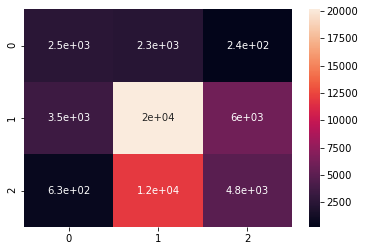

In [91]:
pred = clf.predict(X_val)
print(f1_score(pred, y_val, average = None))
cf_matrix = confusion_matrix(y_val, pred)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)


## Feature selection strategies

### first try chi2, which removes features that seem to be independent from the target variable

In [92]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
# X_train_fs = fs.transform(X_train)
# X_val_fs = fs.transform(X_val)

SelectKBest(k='all', score_func=<function chi2 at 0x7ff8314ed670>)

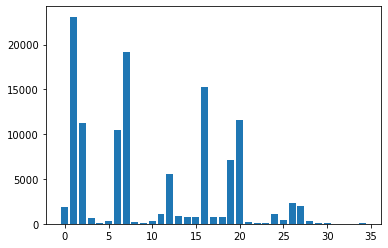

In [93]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Lets choose only features with a chi2 score above 100000

In [94]:
chosen = np.where(fs.scores_>10000)[0]
chosen

array([ 1,  2,  6,  7, 16, 20])

In [95]:
X_train_C = X_train[:,chosen]
X_val_C = X_val[:,chosen]

In [96]:
X_train_C[0]

array([6., 5., 0., 0., 0., 0.])

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix

clf = MultinomialNB()
clf.fit(X_train_C, y_train)
pred = clf.predict(X_train_C)
f1_score(y_train, pred, average="micro") ## we see that the model has poor performance, even on training data

0.5240070990023024

[0.39617738 0.65020396 0.21291186]


<AxesSubplot:>

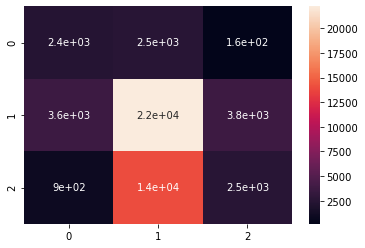

In [98]:
pred = clf.predict(X_val_C)
print(f1_score(pred, y_val, average = None))
cf_matrix = confusion_matrix(y_val, pred)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)


In [99]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train)
# X_train_fs = fs.transform(X_train)
# X_val_fs = fs.transform(X_val)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x7ff82316f9d0>)

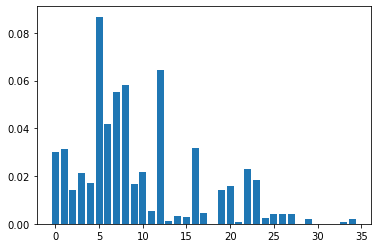

In [100]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [101]:
chosen = np.where(fs.scores_>.03)[0]
chosen

array([ 0,  1,  5,  6,  7,  8, 12, 16])

In [102]:
X_train_M = X_train[:,chosen]
X_val_M = X_val[:,chosen]

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix

clf = MultinomialNB()
clf.fit(X_train_M, y_train)
pred = clf.predict(X_train_M)
f1_score(y_train, pred, average="micro") ## we see that the model has poor performance, even on training data

0.5371162701458173

[0.41381663 0.67386134 0.11614593]


<AxesSubplot:>

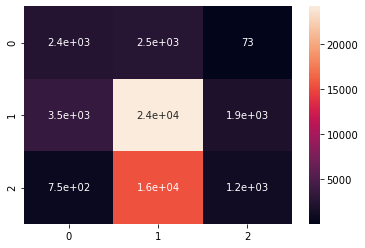

In [103]:
pred = clf.predict(X_val_M)
print(f1_score(pred, y_val, average = None))
cf_matrix = confusion_matrix(y_val, pred)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)


## Now let's try Logistic Regression

### first, establish baseline with no feature selection

In [104]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=2000) # can't finish
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [105]:
pred = model.predict(X_val)
f1_score(y_val, pred, average="micro")

0.5795360795073004

## Try ch2 selected features

In [106]:
model = LogisticRegression(solver='lbfgs', max_iter=2000) # can't finish
model.fit(X_train_C, y_train)

LogisticRegression(max_iter=2000)

In [108]:
pred = model.predict(X_val_C)
f1_score(y_val, pred, average="micro")

ValueError: X has 6 features, but LogisticRegression is expecting 8 features as input.

## Try mutual selected features

In [109]:
model = LogisticRegression(solver='lbfgs', max_iter=2000) # can't finish
model.fit(X_train_M, y_train)

LogisticRegression(max_iter=2000)

In [110]:
pred = model.predict(X_val_M)
f1_score(y_val, pred, average="micro")

0.5717656990464496